In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import and clean the data

In [2]:
# Load the data 
df = pd.read_csv("data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])

# Shorten the column names
df.columns = ["date", "day_type", "bus", "rail", "total"]

# Arrange the rows in chronological order and set the date as index
df = df.sort_values("date").set_index("date")

# Drop the total column because it is only bus + rail
df = df.drop("total", axis=1)

# Drop the duplicates
df = df.drop_duplicates()

df.tail()

day_type     bus    rail
date                               
2022-10-27        W  528826  395129
2022-10-28        W  501985  352842
2022-10-29        A  311437  254149
2022-10-30        U  217204  177961
2022-10-31        W  454862  318942

##### Let's look at day_type

In [3]:
df['day_type'].unique()

array(['U', 'W', 'A'], dtype=object)

We note that U = Sundays or Holidays, W = Weekdays, and A = Saturdays.

# Make time series plots

<IPython.core.display.Javascript object>


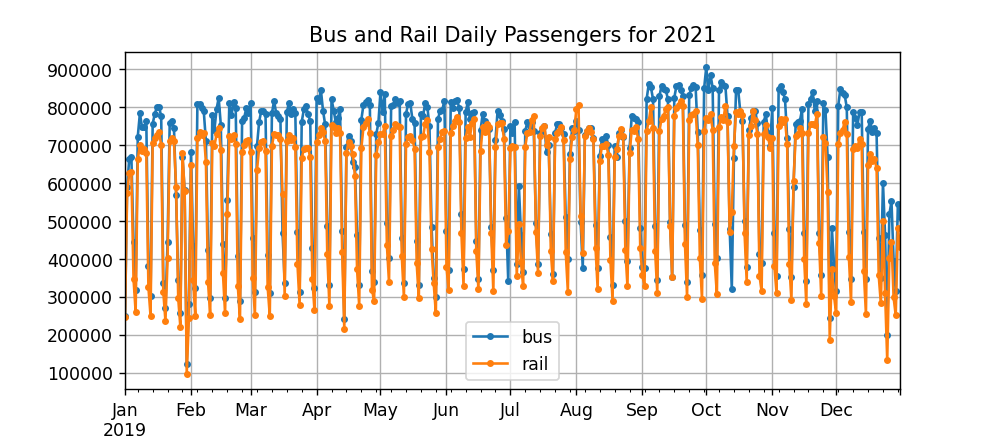

Text(0.5, 1.0, 'Bus and Rail Daily Passengers for 2021')

In [4]:
df["2019-01-01":"2019-12-31"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.title('Bus and Rail Daily Passengers for 2021')

This is a `multivariate time series` because we have multiple values per time step. If we only looked at the bus column we would have a `univariate time series`. Predicting future values is called `forecasting`. We see that there is a weekly pattern. This phenomenon is called `weekly seasonality`.

# Let's look at Mar-May 2019 data only. Let's do a Naive forecast.

**Naive forecasting** in this context means copying the latest known value and use it to forecast the next week's value. We first plot the bus and rail daily passengers overlayed with each other, and then plot the version that is lagged by a week.

In [5]:
# Take the difference between the current date's value with the value 7 days ago 
# for both the bus and rail daily passenger counts
diff_7 = df[['bus', 'rail']].diff(7)["2019-03":"2019-05"]
print(diff_7.head(14))

                bus     rail
date                        
2019-03-01  13927.0 -20019.0
2019-03-02  47280.0  21213.0
2019-03-03  25171.0  11672.0
2019-03-04 -63771.0 -45491.0
2019-03-05 -11268.0  -6517.0
2019-03-06  -6892.0  -2951.0
2019-03-07   6379.0  -3272.0
2019-03-08 -30661.0   1217.0
2019-03-09 -44340.0 -22706.0
2019-03-10  -3112.0  -1448.0
2019-03-11  85268.0  62405.0
2019-03-12  54448.0  36531.0
2019-03-13  -5652.0  18274.0
2019-03-14 -12882.0  15074.0


<IPython.core.display.Javascript object>


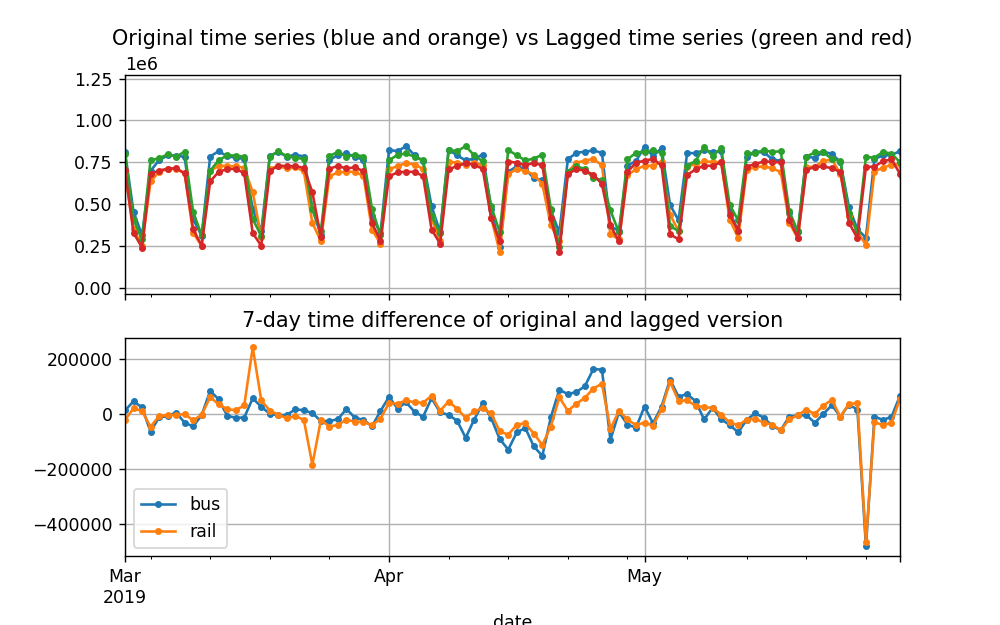

Text(0.5, 1.0, '7-day time difference of original and lagged version')

In [6]:
# Make the plots
fig, axs = plt.subplots(2,1,sharex=True, figsize=(8,5))

## Original and lagged time series
df.plot(ax=axs[0], legend=False, marker=".", label="Lagged") # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, marker=".", label="Lagged") # lagged time series
axs[0].set_title("Original time series (blue and orange) vs Lagged time series (green and red)")

## 7-day difference time series of the original and the lagged version
diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[1].set_title("7-day time difference of original and lagged version")

We notice that the lagged time series and the actual time series have good agreement. When a time series is correlated with a lagged version of itself, we say that the time series is `autocorrelated.` In figure (2), the difference between the original and the lagged version for both bus and rail are fairly small except for the latter part of the month of May. Let's see if there is a holiday during this period.

In [7]:
df.loc["2019-05-25":"2019-05-27"]["day_type"].to_list()

['A', 'U', 'U']

We can see that this is a long weekend (Saturday-Sunday-Holiday).

# Mean Absolute Error (MAE) of the bus and rail daily passenger count

Let's compute for the mean absolute error for the 3-month period. The MAE is a measure of error between the actual and the predicted value.

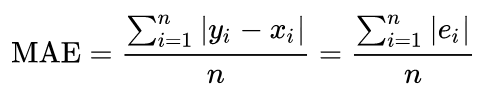

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

We do not know if this is a good score or not. Let's compare the forecast values to the original values using the **Mean Absolute Percentage Error** (MAPE).

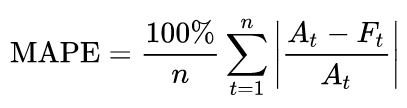

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]

MAPE = (diff_7 / targets).abs().mean() * 100
print(MAPE)

bus     8.293847
rail    8.994765
dtype: float64


The MAPE for bus forecast is around 8.3%, while the MAPE forecast for rail is around 9%. The MAPE for the rail forecast looks slightly better for rail than the bus forecast. **This is because the bus ridership is larger than the rail ridership, so naturally the forecast errors will be much larger**.

# Yearly Seasonality

Mar-May 2019 does not exhibit monthly seasonality. Let's look at data from 2001 to 2019 and examine the data's yearly seasonality.

C:\Users\tonba\AppData\Local\Temp\ipykernel_9432\1008181822.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()


<IPython.core.display.Javascript object>


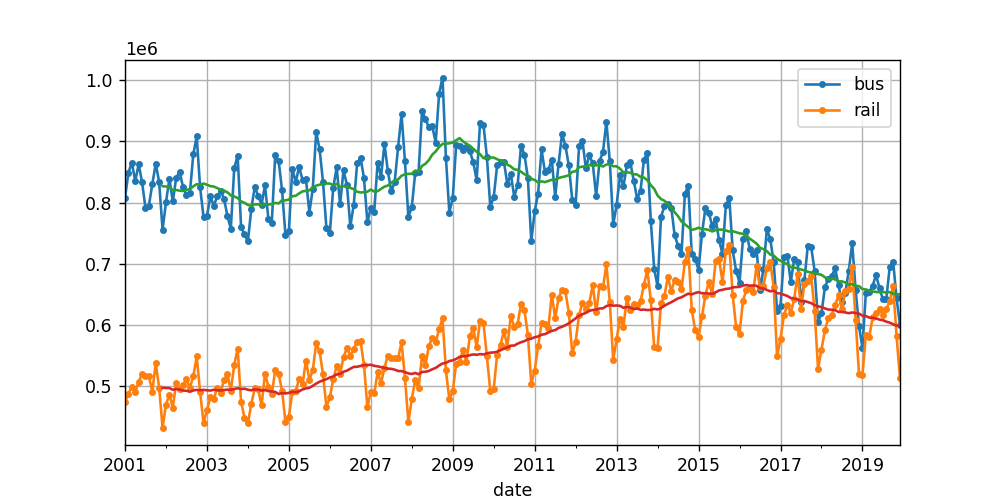

<AxesSubplot: xlabel='date'>

In [10]:
# Get the monthly average
df_monthly = df.resample('M').mean()

# Compute the yearly rolling average.
# We compute the average of the last 12 months. The year 2001 will not be covered since there is no data from 2000.
rolling_average_12_months = df_monthly["2001":"2019"].rolling(window=12).mean()

# Visualize
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly["2001":"2019"].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

There is yearly seasonality but it is noisier than the weekly seasonality. We can also see that the seasonality is more obvious for the rail riders than the bus riders. We also see a linear downward trend from 2016 to 2019.

##### Year difference

Using naive forecasting again, we can copy paste our forecast from the previous year to the current year. To quantify the error, we subtract the ground truth values and the forecasted values:

<IPython.core.display.Javascript object>


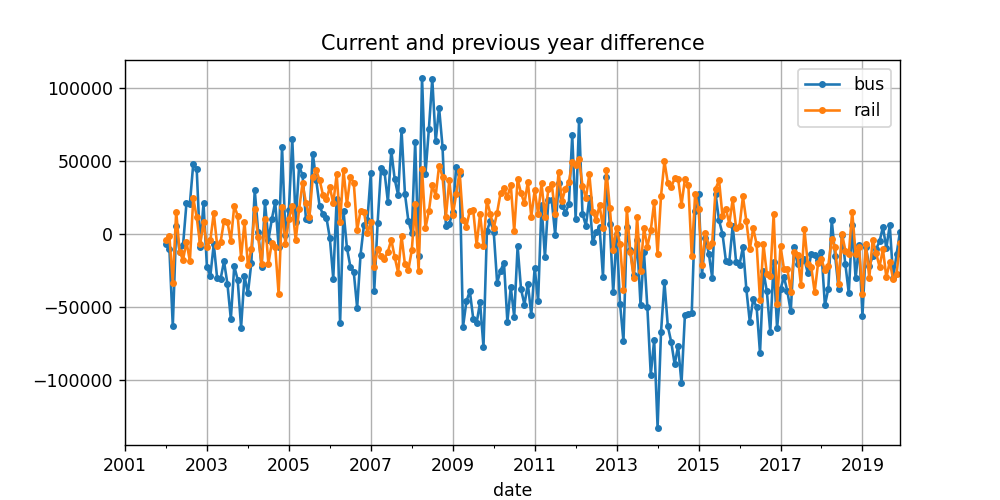

Text(0.5, 1.0, 'Current and previous year difference')

In [11]:
df_monthly.diff(12)["2001":"2019"].plot(grid=True, marker=".", figsize=(8,4))
plt.title('Current and previous year difference')

The differencing removed the yearly seasonality and also the long-term trends. We use this method because it is easier to study a stationary time series (statistical properties remain constant over time without any seasonality or trends). Once you are able to make accurate forecasts on differenced time series, it's easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

# ARMA model family using Statsmodels

### ARMA model
The Autoregressive Moving Average (ARMA) model computes its forecasts using a simple weighted average of lagged values and corrects these forecasts by adding a moving average.

$$\hat{y} = \sum_{i=1}^{p} \alpha_i y_{(t-i)} + \sum_{i=1}^{q} \theta_i \epsilon_{(t-i)}$$

with 

$$\epsilon_{(t)} = y_{(t)} - \hat{y}_{(t)}$$

as the forecast error. Here 

* $\hat{y}_{(t)}$ - model's forecast for time step $t$
* $y_{(t)}$ - ground truth value at time step $t$
* First term is the autoregressive component. It performs regression based on past values. The autoregressive component is a weighted sum of the past $p$ values of the time series using the learnable weights $\alpha_i$. The hyperparameter $p$ determines how far back into the past the model should look. 
* Second term is the moving average of the model. This part is the weighted sum over the past $q$ forecast errors $\epsilon_{(t)}$, using the learnable parameters $\theta_i$.

**The ARMA model assumes stationarity**. If not, then differencing may help. Using differencing over a single time step will produce an approximation of the derivative of the time series. This means that it will eliminate any linear trend, transforming it into a constant value. For example, if you apply one-step differencing to the series [3, 5, 7, 9, 11], you get the differenced series [2, 2, 2, 2].

If the original time series has a quadratic trend instead of a linear trend, then a single round of differencing will not be enough. For example, the series [1, 4, 9, 16, 25, 36] becomes [3, 5, 7, 9, 11] after one round of differencing, but if you run differencing for a second round, then you get [2, 2, 2, 2]. So, running two rounds of differencing will eliminate quadratic trends.

More generally, running $d$ consecutive rounds of differencing computes an approximation of the $d$ order derivative of the time series, so it will eliminate polynomial trends up to degree $d$. This hyperparameter $d$ is called the order of integration.

### ARIMA model

The Autoregressive Integrated Moving Average (ARIMA) model runs $d$ rounds of differencing to make a time series more stationary, then it applies a regular ARMA model. When making forecasts, it uses the existing ARMA model, then adds back the terms that were subtracted by differencing.


### SARIMA model

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model models a time series through the methods of the ARIMA model, but it additionally models a seasonal component for a given frequency (e.g. weekly, monthly, or yearly). It has a total of 7 hyperparameters: $p, d, q$ from ARIMA plus $P,D,Q$ to model seasonality.

##### Let's use the SARIMA model to predict the number of rail riders for the next day

In [12]:
origin, present = "2019-01-01", "2019-05-31"

# Gets data from Jan to May 2019 and sets the dataframe frequency to daily
# This step is important so that the ARIMA class will have no issues when the data is fed to the model
rail_series = df.loc[origin:present]["rail"].asfreq("D")
rail_series.head()

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
Freq: D, Name: rail, dtype: int64

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Invokes the ARIMA class and sets the hyperparameters
model = ARIMA(rail_series, 
              order=(1, 0, 0), # order=(1,0,0) means that p=1, d=0, q=0
              seasonal_order=(0, 1, 1, 7)) # seasonal_order=(0,1,1,7) means that P=0, D=1, Q=1, and s=7

# Fits the ARIMA model
model = model.fit()

# Makes predictions for the next day
y_pred = model.forecast()
print(y_pred)

2019-06-01    427758.626342
Freq: D, dtype: float64


Let's look at the ground truth value:

In [14]:
true_value = df.loc["2019-06-01"]["rail"]
print(100 * (float(y_pred.values) - true_value) / true_value)

12.851971365457102


We are around 13% off from the ground truth value.

##### We run the same code in a loop to make forecasts for each day in March, April, and May, and then compute for the MAE

In [15]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

In [16]:
# Instantiates the predicted rail riders for March-May
y_preds = []

# Loop for predicting the values for March-MAy
for today in time_period.shift(-1): # Shifts the time period to 1 day to the left and uses its rail_rider as the training data
    
    # Train on data up to from 2019-03-01 to "today"
    model = ARIMA(rail_series[origin:today], 
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    
    # Computes the predicted value
    y_pred = model.forecast()[0]
    
    # Appends the predicted value to y_preds
    y_preds.append(y_pred)
    
    
# Converts y_preds into a Pandas Series object
y_preds = pd.Series(y_preds, index=time_period)

# Compute the MAE
mae = (y_preds - rail_series[time_period]).abs().mean()
print(mae)

32040.720101159208


This has a better MAE compared to the naive forecast!

##### Creates plots comparing the ground truth to the predicted values

<IPython.core.display.Javascript object>


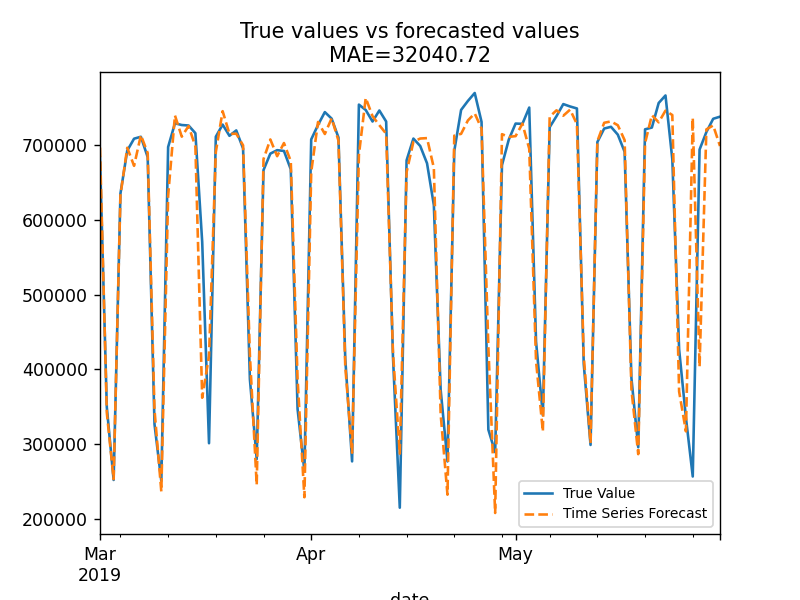

Text(0.5, 1.0, 'True values vs forecasted values\nMAE=32040.72')

In [17]:
plt.figure()
df.loc[start_date:end_date]["rail"].asfreq("D").plot(label="True Value")
y_preds.plot(ls="--", label="Time Series Forecast")
plt.legend(loc=4, fontsize=8)
plt.title("True values vs forecasted values\nMAE={}".format(round(mae,2)))

##### Let's look at the difference between the true and the predicted values

<IPython.core.display.Javascript object>


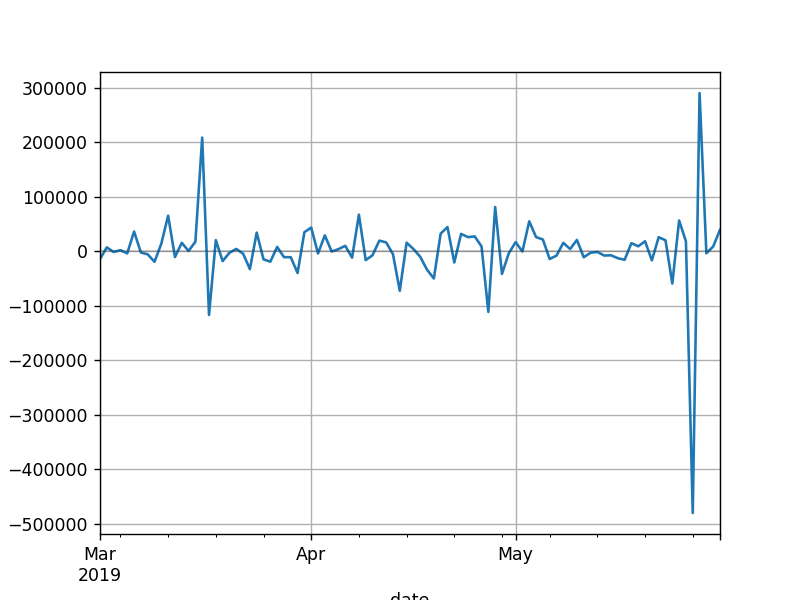

In [18]:
true_pred_diff = df.loc[start_date:end_date]["rail"].asfreq("D").values - y_preds.values

diff_error = pd.DataFrame({'date':time_period, 'diff':true_pred_diff})
diff_error.set_index('date', inplace=True)

# Creates the plot
diff_error.plot(legend=False, grid=True)
plt.axhline(y=0, c='k', lw=0.2)

The time series model performs well! 

# We can then use the predicted values to predict the values for the first week of June

In [19]:
# Gets data from Jan to May 2019 and sets the dataframe frequency to daily
rail_series_original = df.loc["2019-01-01":"2019-05-31"]["rail"].asfreq("D")

# Copies the original rail_series data. Will be appended with the predictions
rail_series_w_forecast = rail_series_original.copy()

for i in range(7): # predict the next 6 days
    model = ARIMA(rail_series_w_forecast, 
                  order=(1, 0, 0), # order=(1,0,0) means that p=1, d=0, q=0
                  seasonal_order=(0, 1, 1, 7)) # seasonal_order=(0,1,1,7) means that P=0, D=1, Q=1, and s=7

    # Fits the ARIMA model
    model = model.fit()

    # Makes predictions for the next day
    y_pred = model.forecast()
    print(y_pred)
    
    # Append to the dataframe
    rail_series_w_forecast = pd.concat([rail_series_w_forecast, y_pred])

2019-06-01    427758.626342
Freq: D, dtype: float64
2019-06-02    323558.699093
Freq: D, dtype: float64
2019-06-03    567133.195309
Freq: D, dtype: float64
2019-06-04    721714.825656
Freq: D, dtype: float64
2019-06-05    737832.376904
Freq: D, dtype: float64
2019-06-06    742657.863002
Freq: D, dtype: float64
2019-06-07    716906.761148
Freq: D, dtype: float64


<IPython.core.display.Javascript object>


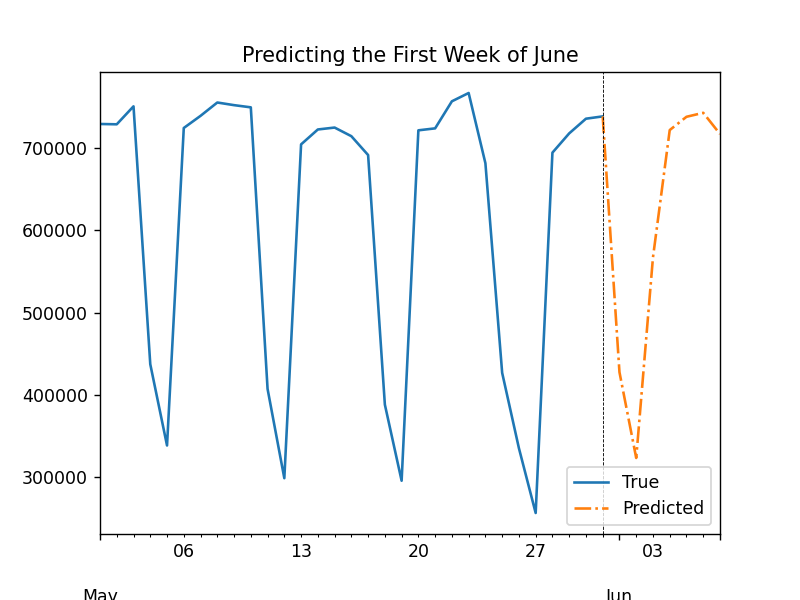

Text(0.5, 1.0, 'Predicting the First Week of June')

In [23]:
# Gets the true value for the relevant date only
true_vals = pd.DataFrame(rail_series_original.loc["2019-05-01":"2019-05-31"])

# Arrange the predicted Series into a pandas dataframe
predicted_vals = pd.DataFrame(rail_series_w_forecast.loc["2019-05-31":"2019-06-07"])
predicted_vals.columns = ['rail']
predicted_vals.index.name = 'date'

# Plot
ax = true_vals.plot(legend=True, label='True Value')
predicted_vals.plot(ax=ax, legend=True, ls='-.', label='Predicted Value')
plt.axvline("2019-05-31", c='k', lw=.5, ls='--')
plt.legend(labels=['True', 'Predicted'], loc=4)
plt.title('Predicting the First Week of June')

# Methods in finding the best hyperparameters:

* Good p, q, P, and Q values are usually fairly small (typically 0 to 2, sometimes up to 5 or 6)
* d and D are typically 0 or 1, sometimes 2. As for s, it’s just the main seasonal pattern’s period: in our case it’s 7 since there’s a strong weekly seasonality. 
    
The model with the lowest MAE wins! The naive and ARIMA forecasts are good baselines for comparing an RNN model. 